# Goal

* Simulating fullCyc Day1 control gradients
  * Not simulating incorporation (all 0% isotope incorp.)
    * Don't know how much true incorporatation for emperical data
* Using parameters inferred from emperical data (fullCyc Day1 seq data), or if not available, default SIPSim parameters
* Determining whether simulated taxa show similar distribution to the emperical  data

## Input parameters
  * phyloseq.bulk file 
  * taxon mapping file
  * list of genomes
  * fragments simulated for all genomes
  * bulk community richness


## workflow

* Creating a community file from OTU abundances in bulk soil samples
  * phyloseq.bulk --> OTU table --> filter to sample --> community table format
* Fragment simulation
  * simulated_fragments --> parse out fragments for target OTUs 
  * simulated_fragments --> parse out fragments from random genomes to obtain richness of interest
  * combine fragment python objects
* Convert fragment lists to kde object
* Add diffusion
* Make incorp config file
* Add isotope incorporation
* Calculating BD shift from isotope incorp
* Simulating gradient fractions
* Simulating OTU table
* Simulating PCR
* Subsampling from the OTU table

## Init

In [80]:
import os
import glob
import re
import nestly

In [81]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [82]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(phyloseq)

## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

# Nestly

* assuming fragments already simulated

In [83]:
workDir = '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/'
buildDir = os.path.join(workDir, 'Day1_default_run')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

fragFile= '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/ampFrags.pkl'
targetFile = '/home/nick/notebook/SIPSim/dev/fullCyc/CD-HIT/target_taxa.txt'

physeqDir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7/phyloseq/'
physeq_bulkCore = 'bulk-core'
physeq_SIP_core = 'SIP-core_unk'


prefrac_comm_abundance = ['1e9']
richness = 2503   # chao1 estimate for bulk Day 1

seq_per_fraction = ['lognormal', 9.432, 0.5, 10000, 30000] # dist, mean, scale, min, max
bulk_days = [1]
nprocs = 24

In [84]:
# building tree structure
nest = nestly.Nest()

## varying params
nest.add('abs', prefrac_comm_abundance)

## set params
nest.add('bulk_day', bulk_days, create_dir=False)
nest.add('percIncorp', [0], create_dir=False)
nest.add('percTaxa', [0], create_dir=False)
nest.add('np', [nprocs], create_dir=False)
nest.add('richness', [richness], create_dir=False)
nest.add('subsample_dist', [seq_per_fraction[0]], create_dir=False)
nest.add('subsample_mean', [seq_per_fraction[1]], create_dir=False)
nest.add('subsample_scale', [seq_per_fraction[2]], create_dir=False)
nest.add('subsample_min', [seq_per_fraction[3]], create_dir=False)
nest.add('subsample_max', [seq_per_fraction[4]], create_dir=False)

### input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)
nest.add('fragFile', [fragFile], create_dir=False)
nest.add('targetFile', [targetFile], create_dir=False)
nest.add('physeqDir', [physeqDir], create_dir=False)
nest.add('physeq_bulkCore', [physeq_bulkCore], create_dir=False)


# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

In [85]:
%%writefile $bashFile
#!/bin/bash

export PATH={R_dir}:$PATH

#-- making DNA pool similar to gradient of interest
echo '# Creating comm file from phyloseq'
phyloseq2comm.r {physeqDir}{physeq_bulkCore} -s 12C-Con -d {bulk_day} > {physeq_bulkCore}_comm.txt
printf 'Number of lines: '; wc -l {physeq_bulkCore}_comm.txt

echo '## Adding target taxa to comm file'
comm_add_target.r {physeq_bulkCore}_comm.txt {targetFile} > {physeq_bulkCore}_comm_target.txt
printf 'Number of lines: '; wc -l {physeq_bulkCore}_comm_target.txt

echo '# Adding extra richness to community file'
printf "1\t{richness}\n" > richness_needed.txt
comm_add_richness.r -s {physeq_bulkCore}_comm_target.txt richness_needed.txt > {physeq_bulkCore}_comm_all.txt
### renaming comm file for downstream pipeline
cat {physeq_bulkCore}_comm_all.txt > {physeq_bulkCore}_comm_target.txt
rm -f {physeq_bulkCore}_comm_all.txt 

echo '## parsing out genome fragments to make simulated DNA pool resembling the gradient of interest'
## all OTUs without an associated reference genome will be assigned a random reference (of the reference genome pool)
### this is done through --NA-random
SIPSim fragment_KDE_parse {fragFile} {physeq_bulkCore}_comm_target.txt \
    --rename taxon_name --NA-random > fragsParsed.pkl


echo '#-- SIPSim pipeline --#'
echo '# converting fragments to KDE'
SIPSim fragment_KDE \
    fragsParsed.pkl \
    > fragsParsed_KDE.pkl
    
echo '# adding diffusion'    
SIPSim diffusion \
    fragsParsed_KDE.pkl \
    --np {np} \
    > fragsParsed_KDE_dif.pkl    

echo '# adding DBL contamination'
SIPSim DBL \
    fragsParsed_KDE_dif.pkl \
    --np {np} \
    > fragsParsed_KDE_dif_DBL.pkl      
    
echo '# making incorp file'
SIPSim incorpConfigExample \
  --percTaxa {percTaxa} \
  --percIncorpUnif {percIncorp} \
  > {percTaxa}_{percIncorp}.config

echo '# adding isotope incorporation to BD distribution'
SIPSim isotope_incorp \
    fragsParsed_KDE_dif_DBL.pkl \
    {percTaxa}_{percIncorp}.config \
    --comm {physeq_bulkCore}_comm_target.txt \
    --np {np} \
    > fragsParsed_KDE_dif_DBL_inc.pkl
    
#echo '# calculating BD shift from isotope incorporation'
#SIPSim BD_shift \
#    fragsParsed_KDE_dif_DBL.pkl \
#    fragsParsed_KDE_dif_DBL_inc.pkl \
#    --np {np} \
#    > fragsParsed_KDE_dif_DBL_inc_BD-shift.txt

echo '# simulating gradient fractions'
SIPSim gradient_fractions \
    {physeq_bulkCore}_comm_target.txt \
    > fracs.txt 

echo '# simulating an OTU table'
SIPSim OTU_table \
    fragsParsed_KDE_dif_DBL_inc.pkl \
    {physeq_bulkCore}_comm_target.txt \
    fracs.txt \
    --abs {abs} \
    --np {np} \
    > OTU_abs{abs}.txt
    
#echo '# simulating PCR'
SIPSim OTU_PCR \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_PCR.txt    
    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}_PCR.txt \
    > OTU_abs{abs}_PCR_sub.txt
        
echo '# making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_w.txt
    
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_meta.txt

Writing /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/Day1_default_run/SIPSimRun.sh


In [86]:
!chmod 777 $bashFile
!cd $workDir; \
    nestrun  --template-file $bashFile -d Day1_default_run --log-file log.txt -j 1

2016-01-15 13:44:26,845 * INFO * Template: ./SIPSimRun.sh
2016-01-15 13:44:26,847 * INFO * [42819] Started ./SIPSimRun.sh in Day1_default_run/1e9
2016-01-15 14:24:38,567 * INFO * [42819] Day1_default_run/1e9 Finished with 0


# -- WAITING -- #

## Checking amplicon fragment BD distribution

### 'Raw' fragments

In [44]:
workDir1 = os.path.join(workDir, 'Day1_default_run/1e9/')

!cd $workDir1; \
    SIPSim KDE_info \
    -s fragsParsed_KDE.pkl \
    > fragsParsed_KDE_info.txt

Loading KDEs...


In [45]:
%%R -i workDir1

inFile = file.path(workDir1, 'fragsParsed_KDE_info.txt')
df = read.delim(inFile, sep='\t') %>%
    filter(KDE_ID == 1)

df %>% head(n=3)

   taxon_ID KDE_ID      min percentile_5 percentile_25     mean   median
1 rand.2144      1 1.700807     1.703438      1.704280 1.704846 1.704823
2 OTU.13854      1 1.704188     1.705113      1.705563 1.705869 1.705852
3  rand.910      1 1.714625     1.717560      1.720371 1.722809 1.722128
  percentile_75 percentile_95      max        stdev
1      1.705328      1.706468 1.710309 0.0009413128
2      1.706141      1.706632 1.709855 0.0004965183
3      1.725485      1.728701 1.730716 0.0033618014


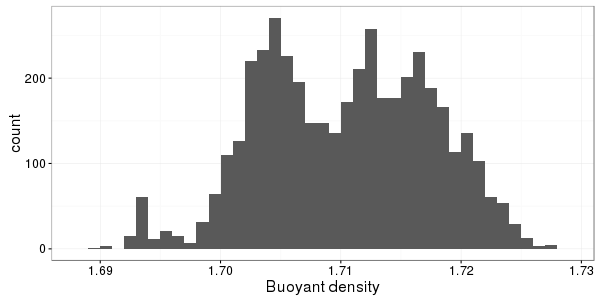

In [46]:
%%R -w 600 -h 300
ggplot(df, aes(median)) +
    geom_histogram(binwidth=0.001) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### fragments w/ diffusion + DBL

In [50]:
workDir1 = os.path.join(workDir, 'Day1_default_run/1e9/')

!cd $workDir1; \
    SIPSim KDE_info \
    -s fragsParsed_KDE_dif_DBL.pkl \
    > fragsParsed_KDE_dif_DBL_info.pkl

Loading KDEs...


In [51]:
%%R -i workDir1

inFile = file.path(workDir1, 'fragsParsed_KDE_dif_DBL_info.pkl')
df = read.delim(inFile, sep='\t') %>%
    filter(KDE_ID == 1)

df %>% head(n=3)

   taxon_ID KDE_ID      min percentile_5 percentile_25     mean   median
1 rand.2144      1 1.643425     1.700443      1.703093 1.704966 1.704855
2 OTU.13854      1 1.645646     1.701624      1.704151 1.705917 1.705850
3  rand.910      1 1.655313     1.715897      1.719785 1.722825 1.722594
  percentile_75 percentile_95      max       stdev
1      1.706641      1.709437 1.789604 0.004186652
2      1.707564      1.710229 1.790373 0.003862533
3      1.725768      1.730186 1.806023 0.005291663


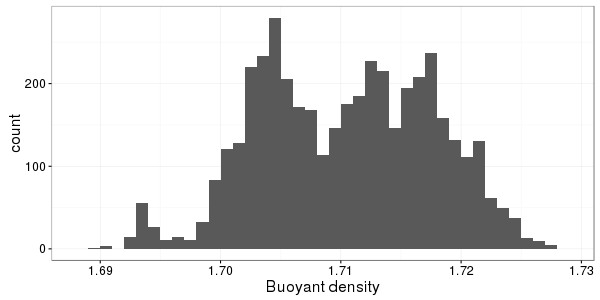

In [52]:
%%R -w 600 -h 300
ggplot(df, aes(median)) +
    geom_histogram(binwidth=0.001) +
    labs(x='Buoyant density') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# BD min/max

* what is the min/max BD that we care about?

In [53]:
%%R
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_BD = min_GC/100.0 * 0.098 + 1.66    
max_BD = max_GC/100.0 * 0.098 + 1.66    

max_BD = max_BD + max_13C_shift_in_BD

cat('Min BD:', min_BD, '\n')
cat('Max BD:', max_BD, '\n')

Min BD: 1.67323 
Max BD: 1.7744 


#  PCR 

In [54]:
# !cd $workDir1; \
#     SIPSim OTU_PCR \
#     OTU_abs1e9.txt \
#     > OTU_abs1e9_PCR.txt

In [55]:
%%R
# # loading file
# F = file.path(workDir1, 'OTU_abs1e9_PCR.txt')
# df.SIM = read.delim(F, sep='\t')

# ggplot(df.SIM, aes(init_molarity, final_molarity)) +
#     geom_point()

NULL


In [56]:
# !cd $workDir1; \
#     SIPSim OTU_subsample \
#     --dist lognormal \
#     --dist_params mean:9.432,sigma:0.5 \
#     --min_size 10000 \
#     --max_size 30000 \
#     OTU_abs1e9_PCR.txt \
#     > OTU_abs1e9_PCR_sub.txt

In [57]:
%%R -h 300 -w 800

# # loading file
# F = file.path(workDir1, 'OTU_abs1e9_PCR_sub.txt')
# df.SIM = read.delim(F, sep='\t')

# # simulated
# df.SIM.s = df.SIM %>% 
#     filter(rel_abund > 0) %>%
#     group_by(BD_mid) %>%
#     summarize(median_abund = median(rel_abund),
#               max_abund = max(rel_abund)) %>%
#     ungroup() %>%
#     rename('Buoyant_density' = BD_mid) %>%
#     mutate(dataset = 'simulated')

# # emperical
# df.EMP.s = df.EMP %>%
#     group_by(Buoyant_density) %>%
#     mutate(rel_abund = abundance / sum(abundance)) %>%
#     filter(rel_abund > 0) %>%
#     summarize(median_abund = median(rel_abund),
#               max_abund = max(rel_abund)) %>%
#     ungroup() %>%
#     mutate(dataset = 'emperical')

# df.j = rbind(df.SIM.s, df.EMP.s) %>%
#     filter(Buoyant_density >= min_BD, 
#            Buoyant_density <= max_BD)

# # plotting
# ggplot(df.j, aes(Buoyant_density, max_abund, color=dataset, group=dataset)) +
#     geom_point() +
#     geom_line() +
#     scale_color_manual(values=c('blue', 'red')) +
#     labs(x='Buoyant density', y='Maximum relative abundance') +
#     theme_bw() +
#     theme( 
#         text = element_text(size=16),
#         legend.position = 'none'
#     )

NULL


## Plotting number of taxa in each fraction

### Emperical data (fullCyc)

In [58]:
%%R 
# simulated OTU table file
OTU.table.dir = '/home/nick/notebook/SIPSim/dev/fullCyc/frag_norm_9_2.5_n5/Day1_default_run/1e9/'
OTU.table.file = 'OTU_abs1e9_PCR_sub.txt'
#OTU.table.file = 'OTU_abs1e9_sub.txt'
#OTU.table.file = 'OTU_abs1e9.txt'

In [59]:
%%R -i physeqDir -i physeq_SIP_core -i bulk_days

# bulk core samples
F = file.path(physeqDir, physeq_SIP_core)
physeq.SIP.core = readRDS(F) 
physeq.SIP.core.m = physeq.SIP.core %>% sample_data

physeq.SIP.core = prune_samples(physeq.SIP.core.m$Substrate == '12C-Con' & 
                                physeq.SIP.core.m$Day %in% bulk_days, 
                                physeq.SIP.core) %>%
    filter_taxa(function(x) sum(x) > 0, TRUE)
physeq.SIP.core.m = physeq.SIP.core %>% sample_data        

physeq.SIP.core

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7025 taxa and 25 samples ]
sample_data() Sample Data:       [ 25 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 7025 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7025 tips and 7024 internal nodes ]


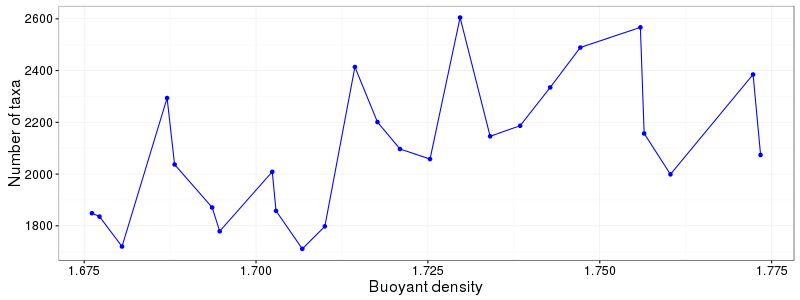

In [60]:
%%R -w 800 -h 300 

## dataframe
df.EMP = physeq.SIP.core %>% otu_table %>%
    as.matrix %>% as.data.frame
df.EMP$OTU = rownames(df.EMP)
df.EMP = df.EMP %>%    
    gather(sample, abundance, 1:(ncol(df.EMP)-1)) 

df.EMP = inner_join(df.EMP, physeq.SIP.core.m, c('sample' = 'X.Sample')) 

df.EMP.nt = df.EMP %>%
    group_by(sample) %>%
    mutate(n_taxa = sum(abundance > 0)) %>%
    ungroup() %>%
    distinct(sample) %>%
    filter(Buoyant_density >= min_BD, 
           Buoyant_density <= max_BD)
    

## plotting
p = ggplot(df.EMP.nt, aes(Buoyant_density, n_taxa)) +
    geom_point(color='blue') +
    geom_line(color='blue') +
    #geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

### w/ simulated data

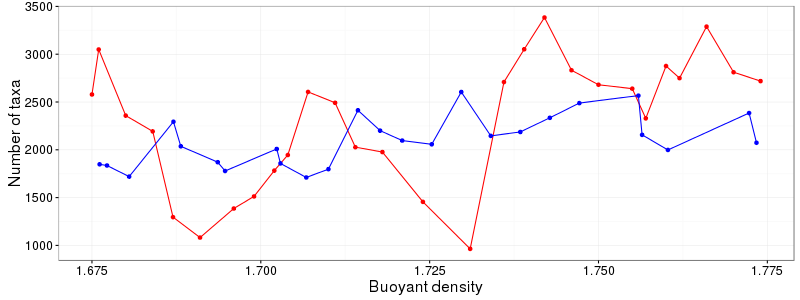

In [61]:
%%R -w 800 -h 300

# loading file
F = file.path(workDir1, OTU.table.file)
df.SIM = read.delim(F, sep='\t')

## edit table
df.SIM.nt = df.SIM %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n()) %>%
    filter(BD_mid >= min_BD, 
           BD_mid <= max_BD)
    

## plot
p = ggplot(df.SIM.nt, aes(BD_mid, n_taxa)) +
    geom_point(color='red') +
    geom_line(color='red') +
    geom_point(data=df.EMP.nt, aes(x=Buoyant_density), color='blue') +
    geom_line(data=df.EMP.nt, aes(x=Buoyant_density), color='blue') +
    #geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

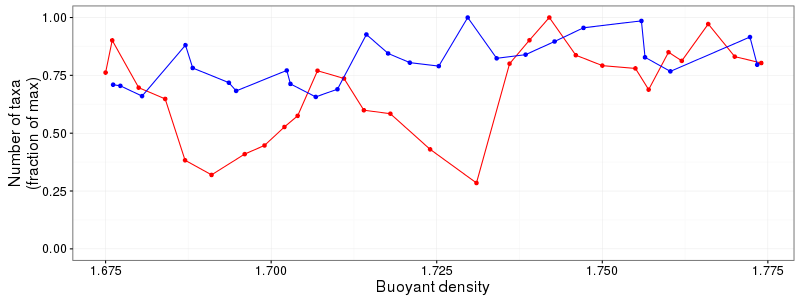

In [62]:
%%R -w 800 -h 300
# normalized by max number of taxa

## edit table
df.SIM.nt = df.SIM.nt %>%
    group_by() %>%
    mutate(n_taxa_norm = n_taxa / max(n_taxa))

df.EMP.nt = df.EMP.nt %>%
    group_by() %>%
    mutate(n_taxa_norm = n_taxa / max(n_taxa))


## plot
p = ggplot(df.SIM.nt, aes(BD_mid, n_taxa_norm)) +
    geom_point(color='red') +
    geom_line(color='red') +
    geom_point(data=df.EMP.nt, aes(x=Buoyant_density), color='blue') +
    geom_line(data=df.EMP.nt, aes(x=Buoyant_density), color='blue') +
    #geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    scale_y_continuous(limits=c(0, 1)) +
    labs(x='Buoyant density', y='Number of taxa\n(fraction of max)') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

## Total sequence count

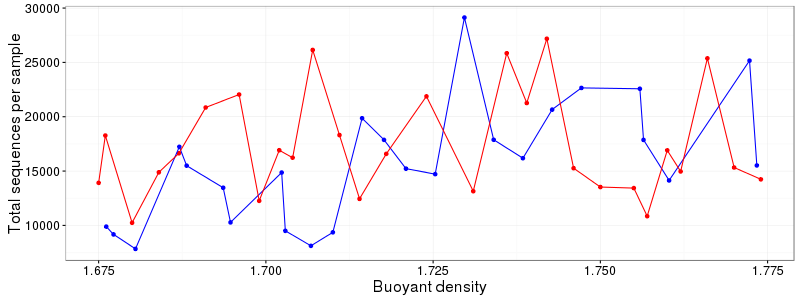

In [63]:
%%R -w 800 -h 300

# simulated
df.SIM.s = df.SIM %>%
    group_by(library, BD_mid) %>%
    summarize(total_abund = sum(count)) %>%
    rename('Day' = library, 'Buoyant_density' = BD_mid) %>%
    ungroup() %>%
    mutate(dataset='simulated')
# emperical
df.EMP.s = df.EMP %>% 
    group_by(Day, Buoyant_density) %>%
    summarize(total_abund = sum(abundance))  %>%
    ungroup() %>%
    mutate(dataset='emperical')

# join
df.j = rbind(df.SIM.s, df.EMP.s) %>%
    filter(Buoyant_density >= min_BD, 
           Buoyant_density <= max_BD)
    
df.SIM.s = df.EMP.s = ""

# plot
ggplot(df.j, aes(Buoyant_density, total_abund, color=dataset)) +
    geom_point() +
    geom_line() +
    scale_color_manual(values=c('blue', 'red')) +
    labs(x='Buoyant density', y='Total sequences per sample') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )

## Plotting Shannon diversity for each

In [64]:
%%R
shannon_index_long = function(df, abundance_col, ...){
    # calculating shannon diversity index from a 'long' formated table
    ## community_col = name of column defining communities
    ## abundance_col = name of column defining taxon abundances
    df = df %>% as.data.frame
    cmd = paste0(abundance_col, '/sum(', abundance_col, ')')
    df.s = df %>%
        group_by_(...) %>%
        mutate_(REL_abundance = cmd) %>%
        mutate(pi__ln_pi = REL_abundance * log(REL_abundance),
               shannon = -sum(pi__ln_pi, na.rm=TRUE)) %>%
        ungroup() %>% 
        dplyr::select(-REL_abundance, -pi__ln_pi) %>%
        distinct_(...) 
    return(df.s)
}

In [65]:
%%R
# calculating shannon
df.SIM.shan = shannon_index_long(df.SIM, 'count', 'library', 'fraction') %>%
    filter(BD_mid >= min_BD, 
           BD_mid <= max_BD)
    
df.EMP.shan = shannon_index_long(df.EMP, 'abundance', 'sample') %>%
    filter(Buoyant_density >= min_BD, 
           Buoyant_density <= max_BD)
    

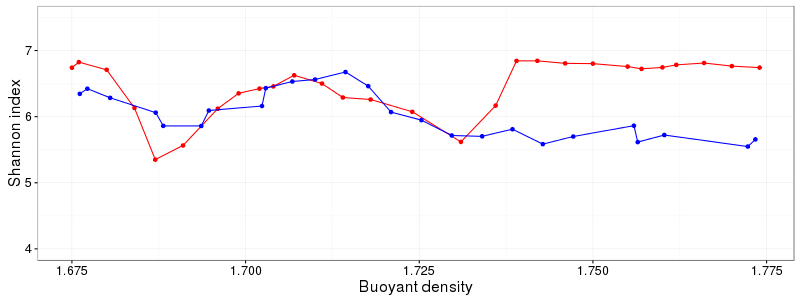

In [66]:
%%R -w 800 -h 300
# plotting
p = ggplot(df.SIM.shan, aes(BD_mid, shannon)) +
    geom_point(color='red') +
    geom_line(color='red') +
    geom_point(data=df.EMP.shan, aes(x=Buoyant_density), color='blue') +
    geom_line(data=df.EMP.shan, aes(x=Buoyant_density), color='blue') +
    #geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    scale_y_continuous(limits=c(4, 7.5)) +
    labs(x='Buoyant density', y='Shannon index') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

# min/max abundances of taxa

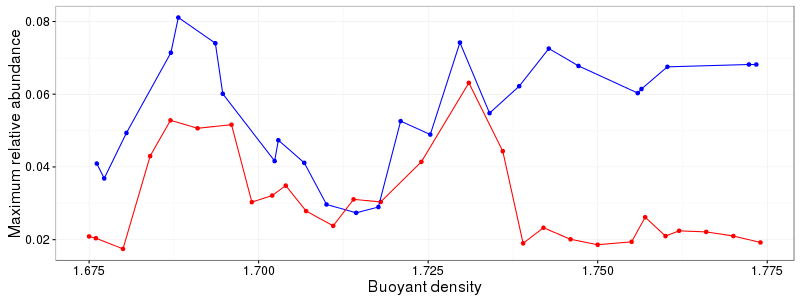

In [67]:
%%R -h 300 -w 800

# simulated
df.SIM.s = df.SIM %>% 
    filter(rel_abund > 0) %>%
    group_by(BD_mid) %>%
    summarize(min_abund = min(rel_abund),
              max_abund = max(rel_abund)) %>%
    ungroup() %>%
    rename('Buoyant_density' = BD_mid) %>%
    mutate(dataset = 'simulated')

# emperical
df.EMP.s = df.EMP %>%
    group_by(Buoyant_density) %>%
    mutate(rel_abund = abundance / sum(abundance)) %>%
    filter(rel_abund > 0) %>%
    summarize(min_abund = min(rel_abund),
              max_abund = max(rel_abund)) %>%
    ungroup() %>%
    mutate(dataset = 'emperical')

df.j = rbind(df.SIM.s, df.EMP.s) %>%
    filter(Buoyant_density >= min_BD, 
           Buoyant_density <= max_BD)
    

# plotting
ggplot(df.j, aes(Buoyant_density, max_abund, color=dataset, group=dataset)) +
    geom_point() +
    geom_line() +
    scale_color_manual(values=c('blue', 'red')) +
    labs(x='Buoyant density', y='Maximum relative abundance') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )

## Plotting rank-abundance of heavy fractions

* In heavy fractions, is DBL resulting in approx. equal abundances among taxa?

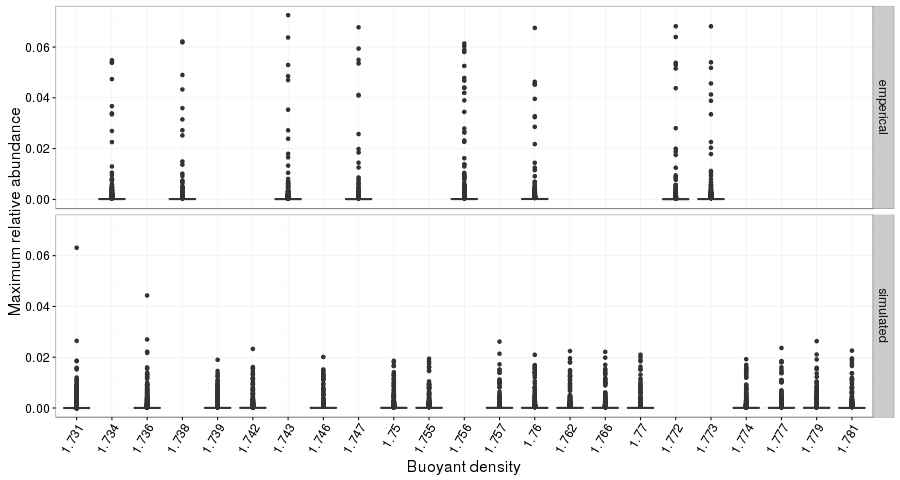

In [69]:
%%R -w 900


# simulated
df.SIM.s = df.SIM %>%
    select(BD_mid, rel_abund) %>%
    rename('Buoyant_density' = BD_mid) %>%
    mutate(dataset='simulated') 
# emperical
df.EMP.s = df.EMP %>% 
    group_by(Buoyant_density) %>%
    mutate(rel_abund = abundance / sum(abundance)) %>%
    ungroup() %>%
    filter(rel_abund > 0) %>%
    select(Buoyant_density, rel_abund) %>%
    mutate(dataset='emperical') 

# join
df.j = rbind(df.SIM.s, df.EMP.s) %>%
    filter(Buoyant_density > 1.73) %>%
    mutate(Buoyant_density = round(Buoyant_density, 3),
           Buoyant_density_c = as.character(Buoyant_density))

df.j$Buoyant_density_c = reorder(df.j$Buoyant_density_c, df.j$Buoyant_density)

ggplot(df.j, aes(Buoyant_density_c, rel_abund)) +
    geom_boxplot() +
    scale_color_manual(values=c('blue', 'red')) +
    labs(x='Buoyant density', y='Maximum relative abundance') +
    facet_grid(dataset ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        axis.text.x = element_text(angle=60, hjust=1),
        legend.position = 'none'
    )

# BD range where an OTU is detected 

* Do the simulated OTU BD distributions span the same BD range of the emperical data?

### Simulated

In [70]:
%%R

# loading comm file
F = file.path(workDir1, 'bulk-core_comm_target.txt')
df.comm = read.delim(F, sep='\t') %>%
    dplyr::select(library, taxon_name, rel_abund_perc) %>%
    rename('bulk_abund' = rel_abund_perc) %>%
    mutate(bulk_abund = bulk_abund / 100)


## joining
df.SIM.j = inner_join(df.SIM, df.comm, c('library' = 'library',
                                         'taxon' = 'taxon_name')) %>%
    filter(BD_mid >= min_BD, 
           BD_mid <= max_BD)
    
df.SIM.j %>% head(n=3)

  library    fraction taxon BD_min BD_mid BD_max count   rel_abund bulk_abund
1       1 1.674-1.675 OTU.1  1.674  1.675  1.675    88 0.006323202 0.02801777
2       1 1.675-1.678 OTU.1  1.675  1.676  1.678   176 0.009630116 0.02801777
3       1 1.678-1.682 OTU.1  1.678  1.680  1.682    86 0.008394339 0.02801777


### Emperical

In [71]:
%%R
bulk_days = c(1)

In [72]:
%%R
physeq.dir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7/phyloseq/'
physeq.bulk = 'bulk-core'
physeq.file = file.path(physeq.dir, physeq.bulk)
physeq.bulk = readRDS(physeq.file)
physeq.bulk.m = physeq.bulk %>% sample_data
physeq.bulk = prune_samples(physeq.bulk.m$Exp_type == 'microcosm_bulk' &
                            physeq.bulk.m$Day %in% bulk_days, physeq.bulk)

physeq.bulk.m = physeq.bulk %>% sample_data
physeq.bulk

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4950 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 4950 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4950 tips and 4949 internal nodes ]


In [73]:
%%R
physeq.bulk.n = transform_sample_counts(physeq.bulk, function(x) x/sum(x))
physeq.bulk.n

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4950 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 4950 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4950 tips and 4949 internal nodes ]


In [74]:
%%R
# making long format of each bulk table
bulk.otu = physeq.bulk.n %>% otu_table %>% as.data.frame
ncol = ncol(bulk.otu)
bulk.otu$OTU = rownames(bulk.otu)
bulk.otu = bulk.otu %>%
    gather(sample, abundance, 1:ncol) 

bulk.otu = inner_join(physeq.bulk.m, bulk.otu, c('X.Sample' = 'sample')) %>%
    dplyr::select(OTU, abundance) %>%
    rename('bulk_abund' = abundance)
bulk.otu %>% head(n=3)

       OTU   bulk_abund
1 OTU.1101 1.234263e-04
2 OTU.1130 6.171316e-05
3 OTU.9833 0.000000e+00


In [75]:
%%R
# joining tables
df.EMP.j = inner_join(df.EMP, bulk.otu, c('OTU' = 'OTU')) %>%
    filter(Buoyant_density >= min_BD, 
           Buoyant_density <= max_BD)
    
df.EMP.j %>% head(n=3)

       OTU            sample abundance primer_number fwd_barcode rev_barcode
1 OTU.1101 12C-Con.D1.R2_F23         2           134    TCGACGAG    TGAGTACG
2 OTU.1130 12C-Con.D1.R2_F23         0           134    TCGACGAG    TGAGTACG
3 OTU.9833 12C-Con.D1.R2_F23         0           134    TCGACGAG    TGAGTACG
  Substrate Day Microcosm_replicate Fraction Buoyant_density Sample_type
1   12C-Con   1                   2       23         1.69362     unknown
2   12C-Con   1                   2       23         1.69362     unknown
3   12C-Con   1                   2       23         1.69362     unknown
         library Exp_type Sample_location Sample_date Sample_treatment
1 150721_V4_Lib4      SIP              NA          NA               NA
2 150721_V4_Lib4      SIP              NA          NA               NA
3 150721_V4_Lib4      SIP              NA          NA               NA
  Sample_subtreatment core_dataset   bulk_abund
1                  NA         TRUE 1.234263e-04
2                  N

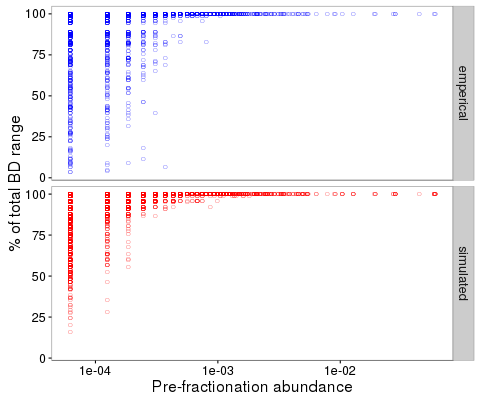

In [76]:
%%R -h 400
# filtering & combining emperical w/ simulated data

## emperical 
max_BD_range = max(df.EMP.j$Buoyant_density) - min(df.EMP.j$Buoyant_density)
df.EMP.j.f = df.EMP.j %>%
    filter(abundance > 0) %>%
    group_by(OTU) %>%
    summarize(mean_rel_abund = mean(bulk_abund),
              min_BD = min(Buoyant_density),
              max_BD = max(Buoyant_density),
              BD_range = max_BD - min_BD,
              BD_range_perc = BD_range / max_BD_range * 100) %>%
    ungroup() %>%
    mutate(dataset = 'emperical')

## simulated
max_BD_range = max(df.SIM.j$BD_mid) - min(df.SIM.j$BD_mid)
df.SIM.j.f = df.SIM.j %>%
    filter(count > 0) %>%
    group_by(taxon) %>%
    summarize(mean_rel_abund = mean(bulk_abund),
              min_BD = min(BD_mid),
              max_BD = max(BD_mid),
              BD_range = max_BD - min_BD,
              BD_range_perc = BD_range / max_BD_range * 100) %>%
    ungroup() %>%
    rename('OTU' = taxon) %>%
    mutate(dataset = 'simulated')

## join
df.j = rbind(df.EMP.j.f, df.SIM.j.f) %>%
    filter(BD_range_perc > 0,
            mean_rel_abund > 0)

## plotting
ggplot(df.j, aes(mean_rel_abund, BD_range_perc, color=dataset)) +
    geom_point(alpha=0.5, shape='O') +
    #stat_density2d() +
    #scale_fill_gradient(low='white', high='red', na.value='grey50') +
    #scale_x_log10(limits=c(min(df.j$mean_rel_abund, na.rm=T), 1e-2)) +
    #scale_y_continuous(limits=c(95, 100)) +
    scale_x_log10() +
    scale_y_continuous() +
    scale_color_manual(values=c('blue', 'red')) +
    labs(x='Pre-fractionation abundance', y='% of total BD range') +
    #geom_vline(xintercept=0.001, linetype='dashed', alpha=0.5) +
    facet_grid(dataset ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid = element_blank(),
        legend.position = 'none'
        )


# Plotting abundance distributions

In [77]:
%%R 

## emperical 
df.EMP.j.f = df.EMP.j %>%
    filter(abundance > 0) %>%
    dplyr::select(OTU, sample, abundance, Buoyant_density, bulk_abund) %>%
    mutate(dataset = 'emperical') 

## simulated
df.SIM.j.f = df.SIM.j %>%
    filter(count > 0) %>%
    dplyr::select(taxon, fraction, count, BD_mid, bulk_abund) %>%
    rename('OTU' = taxon,
           'sample' = fraction,
           'Buoyant_density' = BD_mid,
           'abundance' = count) %>%
    mutate(dataset = 'simulated') 

df.j = rbind(df.EMP.j.f, df.SIM.j.f) %>%
    group_by(sample) %>%
    mutate(rel_abund = abundance / sum(abundance))

df.j %>% head(n=3) %>% as.data.frame

       OTU            sample abundance Buoyant_density   bulk_abund   dataset
1 OTU.1101 12C-Con.D1.R2_F23         2         1.69362 1.234263e-04 emperical
2 OTU.1249 12C-Con.D1.R2_F23         1         1.69362 0.000000e+00 emperical
3 OTU.1653 12C-Con.D1.R2_F23         1         1.69362 6.171316e-05 emperical
     rel_abund
1 1.527417e-04
2 7.637086e-05
3 7.637086e-05


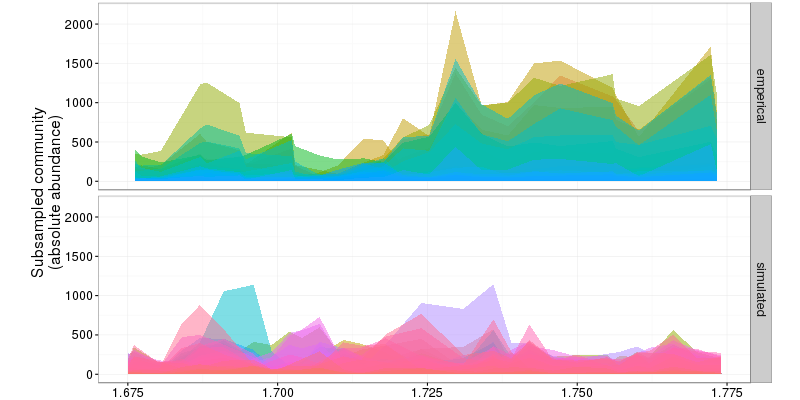

In [78]:
%%R -w 800 -h 400

# plotting absolute abundances of subsampled
## plot
p = ggplot(df.j, aes(Buoyant_density, abundance, fill=OTU)) +
    geom_area(stat='identity', position='dodge', alpha=0.5) +
    #geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Subsampled community\n(absolute abundance)') +
    facet_grid(dataset ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none',
          axis.title.y = element_text(vjust=1),        
          axis.title.x = element_blank(),
          plot.margin=unit(c(0.1,1,0.1,1), "cm")
         )
p

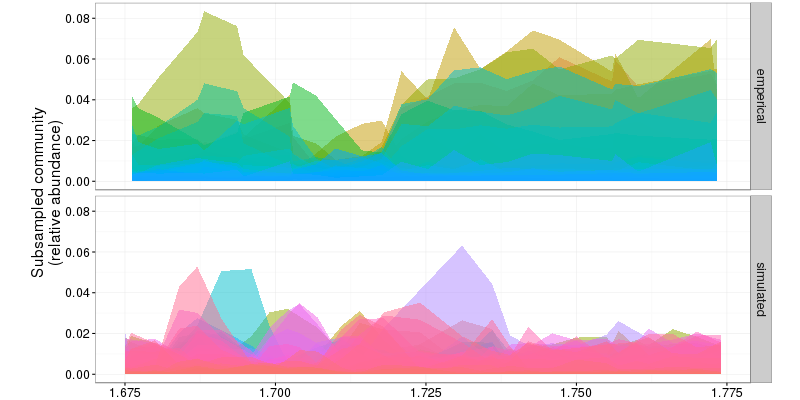

In [79]:
%%R -w 800 -h 400

# plotting relative abundances of subsampled
p = ggplot(df.j, aes(Buoyant_density, rel_abund, fill=OTU)) +
    geom_area(stat='identity', position='dodge', alpha=0.5) +
    #geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Subsampled community\n(relative abundance)') +
    facet_grid(dataset ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none',
          axis.title.y = element_text(vjust=1),        
          axis.title.x = element_blank(),
          plot.margin=unit(c(0.1,1,0.1,1), "cm")
         )
p

# --OLD--

# Determining the pre-fractionation abundances of taxa in each gradient fraction

* emperical data
* low-abundant taxa out at the tails?
* OR broad distributions of high abundant taxa

In [114]:
%%R
physeq.SIP.core.n = transform_sample_counts(physeq.SIP.core, function(x) x/sum(x))
physeq.SIP.core.n

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7025 taxa and 25 samples ]
sample_data() Sample Data:       [ 25 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 7025 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7025 tips and 7024 internal nodes ]


In [118]:
%%R
physeq.dir = '/var/seq_data/fullCyc/MiSeq_16SrRNA/515f-806r/lib1-7/phyloseq/'
physeq.bulk = 'bulk-core'
physeq.file = file.path(physeq.dir, physeq.bulk)
physeq.bulk = readRDS(physeq.file)
physeq.bulk.m = physeq.bulk %>% sample_data
physeq.bulk = prune_samples(physeq.bulk.m$Exp_type == 'microcosm_bulk' &
                            physeq.bulk.m$Day %in% bulk_days, physeq.bulk)

physeq.bulk.m = physeq.bulk %>% sample_data
physeq.bulk

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4950 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 4950 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4950 tips and 4949 internal nodes ]


In [119]:
%%R
physeq.bulk.n = transform_sample_counts(physeq.bulk, function(x) x/sum(x))
physeq.bulk.n

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4950 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 4950 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4950 tips and 4949 internal nodes ]


In [136]:
%%R
# making long format of SIP OTU table
SIP.otu = physeq.SIP.core.n %>% otu_table %>% as.data.frame
ncol = ncol(SIP.otu)
SIP.otu$OTU = rownames(SIP.otu)
SIP.otu = SIP.otu %>%
    gather(sample, abundance, 1:ncol) 

SIP.otu = inner_join(physeq.SIP.core.m, SIP.otu, c('X.Sample' = 'sample')) %>%
    select(-core_dataset, -Sample_location, -Sample_date, -Sample_treatment,
           -Sample_subtreatment, -library, -Sample_type)
SIP.otu %>% head(n=3)

           X.Sample primer_number fwd_barcode rev_barcode Substrate Day
1 12C-Con.D1.R2_F23           134    TCGACGAG    TGAGTACG   12C-Con   1
2 12C-Con.D1.R2_F23           134    TCGACGAG    TGAGTACG   12C-Con   1
3 12C-Con.D1.R2_F23           134    TCGACGAG    TGAGTACG   12C-Con   1
  Microcosm_replicate Fraction Buoyant_density Exp_type      OTU    abundance
1                   2       23         1.69362      SIP OTU.1101 0.0001485001
2                   2       23         1.69362      SIP OTU.1130 0.0000000000
3                   2       23         1.69362      SIP OTU.9833 0.0000000000


In [137]:
%%R
# making long format of each bulk table
bulk.otu = physeq.bulk.n %>% otu_table %>% as.data.frame
ncol = ncol(bulk.otu)
bulk.otu$OTU = rownames(bulk.otu)
bulk.otu = bulk.otu %>%
    gather(sample, abundance, 1:ncol) 

bulk.otu = inner_join(physeq.bulk.m, bulk.otu, c('X.Sample' = 'sample')) %>%
    select(OTU, abundance) %>%
    rename('bulk_abund' = abundance)
bulk.otu %>% head(n=3)

       OTU   bulk_abund
1 OTU.1101 1.234263e-04
2 OTU.1130 6.171316e-05
3 OTU.9833 0.000000e+00


In [138]:
%%R
# joining tables
SIP.otu = inner_join(SIP.otu, bulk.otu, c('OTU' = 'OTU'))
SIP.otu %>% head(n=3)

           X.Sample primer_number fwd_barcode rev_barcode Substrate Day
1 12C-Con.D1.R2_F23           134    TCGACGAG    TGAGTACG   12C-Con   1
2 12C-Con.D1.R2_F23           134    TCGACGAG    TGAGTACG   12C-Con   1
3 12C-Con.D1.R2_F23           134    TCGACGAG    TGAGTACG   12C-Con   1
  Microcosm_replicate Fraction Buoyant_density Exp_type      OTU    abundance
1                   2       23         1.69362      SIP OTU.1101 0.0001485001
2                   2       23         1.69362      SIP OTU.1130 0.0000000000
3                   2       23         1.69362      SIP OTU.9833 0.0000000000
    bulk_abund
1 1.234263e-04
2 6.171316e-05
3 0.000000e+00


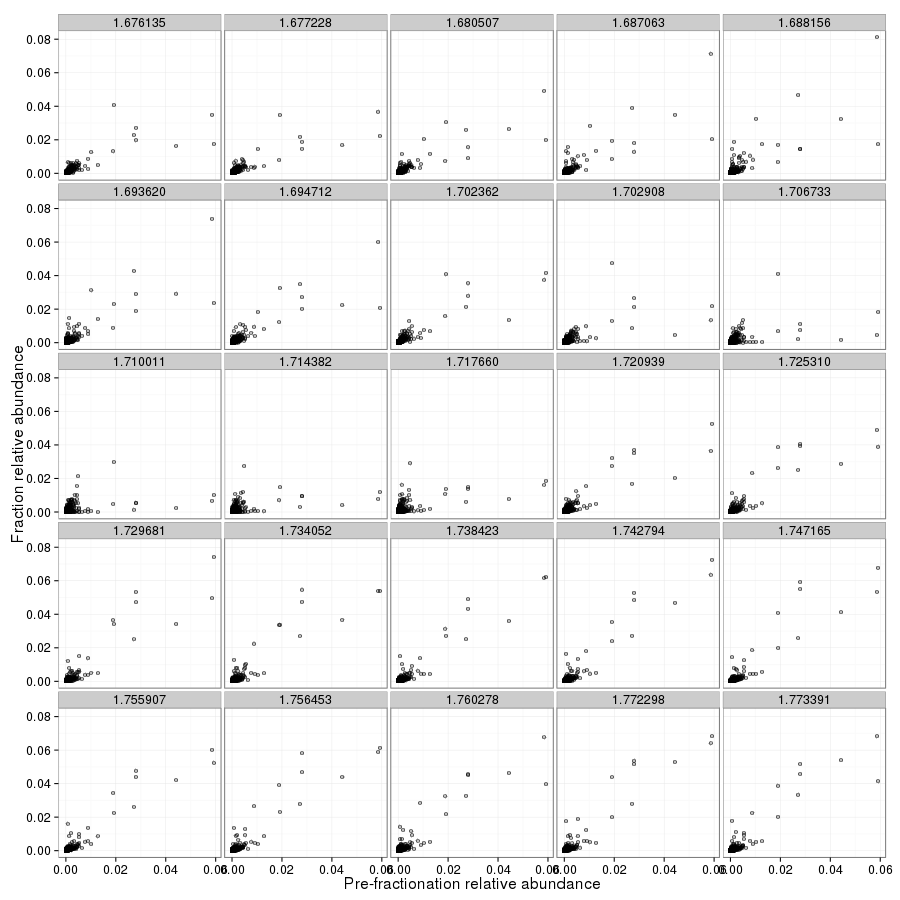

In [147]:
%%R -w 900 -h 900
# for each gradient, plotting gradient rel_abund vs bulk rel_abund

ggplot(SIP.otu, aes(bulk_abund, abundance)) +
    geom_point(alpha=0.2) +
    geom_point(shape='O', alpha=0.6) +
    facet_wrap(~ Buoyant_density) +
    labs(x='Pre-fractionation relative abundance', 
         y='Fraction relative abundance') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

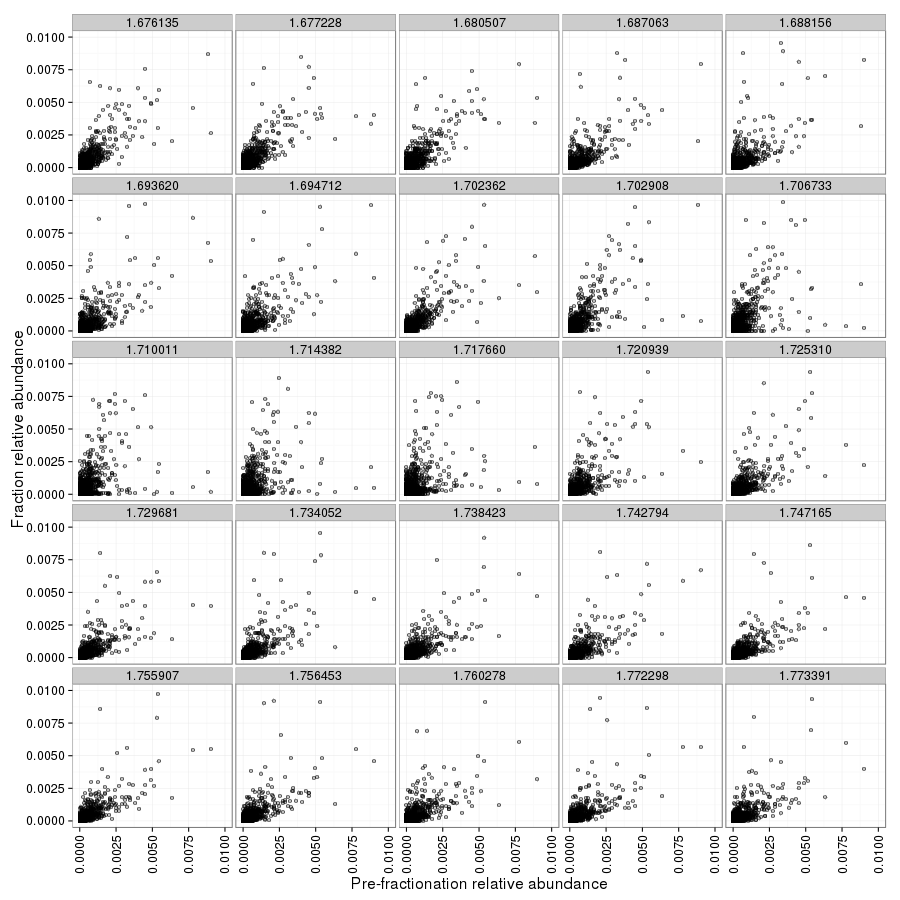

In [152]:
%%R -w 900 -h 900
# for each gradient, plotting gradient rel_abund vs bulk rel_abund

ggplot(SIP.otu, aes(bulk_abund, abundance)) +
    geom_point(alpha=0.2) +
    geom_point(shape='O', alpha=0.6) +
    scale_x_continuous(limits=c(0,0.01)) +
    scale_y_continuous(limits=c(0,0.01)) +
    facet_wrap(~ Buoyant_density) +
    labs(x='Pre-fractionation relative abundance', 
         y='Fraction relative abundance') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5)
    )

## Plotting the abundance distribution of top 10 most abundant taxa (bulk samples) 

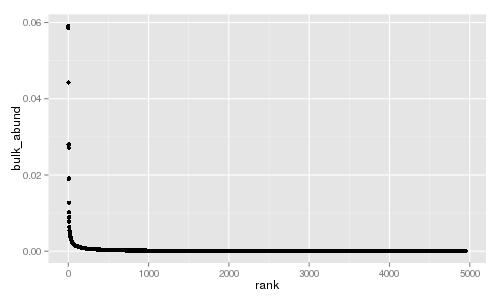

In [169]:
%%R -w 500 -h 300
# checking bulk rank-abundance
tmp = bulk.otu %>%
    mutate(rank = row_number(-bulk_abund))

ggplot(tmp, aes(rank, bulk_abund)) +
    geom_point()

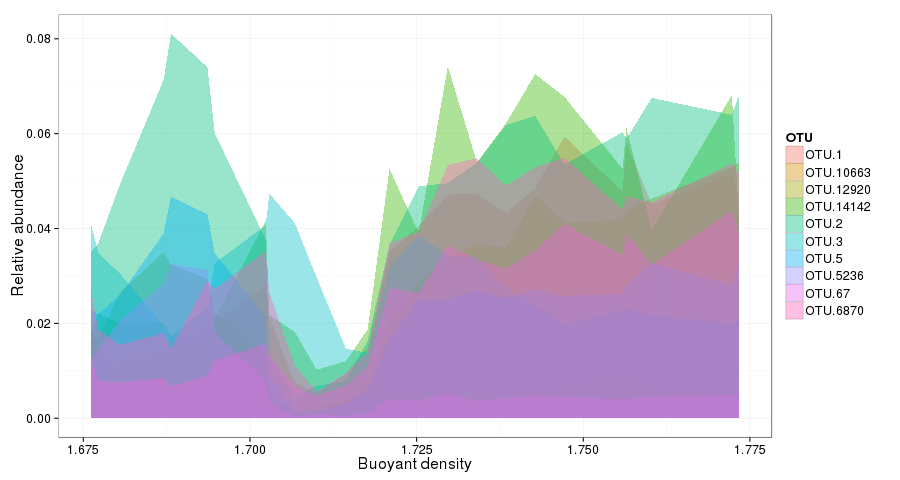

In [183]:
%%R -w 900
top.n = filter(tmp, rank <= 10)
SIP.otu.f = SIP.otu %>%
    filter(OTU %in% top.n$OTU) 

ggplot(SIP.otu.f, aes(Buoyant_density, abundance, group=OTU, fill=OTU)) +
    #geom_point() +
    #geom_line() +
    geom_area(position='dodge', alpha=0.4) +
    labs(y='Relative abundance', x='Buoyant density') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

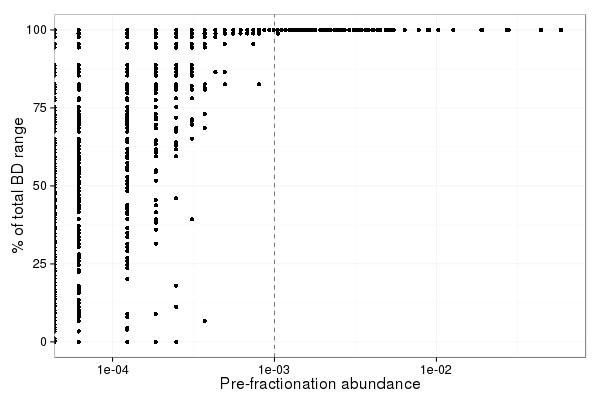

In [209]:
%%R -w 600 -h 400
# Number of gradients that each OTU is found in

max_BD_range = max(SIP.otu$Buoyant_density) - min(SIP.otu$Buoyant_density)

SIP.otu.f = SIP.otu %>%
    filter(abundance > 0) %>%
    group_by(OTU) %>%
    summarize(bulk_abund = mean(bulk_abund),
              min_BD = min(Buoyant_density),
              max_BD = max(Buoyant_density),
              BD_range = max_BD - min_BD,
              BD_range_perc = BD_range / max_BD_range * 100) %>%
    ungroup() 


ggplot(SIP.otu.f, aes(bulk_abund, BD_range_perc, group=OTU)) +
    geom_point() +
    scale_x_log10() +
    labs(x='Pre-fractionation abundance', y='% of total BD range') +
    geom_vline(xintercept=0.001, linetype='dashed', alpha=0.5) +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )
    

#### Notes

* Currently, simulated taxa with an abundance of >0.1% are detected in approx. all fractions.